In [ ]:
import tensorflow as tf
import os
from glob import glob
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import  models, optimizers, callbacks
from tensorflow.keras import backend as K

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# **FLAME**

In [ ]:
# Paths to the image and mask directories Flame
image_dir = '/content/drive/MyDrive/Final_Project/datasetUnet/custom_dataset_flame/Image'
mask_dir = '/content/drive/MyDrive/Final_Project/datasetUnet/custom_dataset_flame/Mask'

# Paths to the new mosaic image and mask directories
new_image_dir = '/content/drive/MyDrive/Final_Project/datasetUnet/custom_dataset_flame/New_Image'
new_mask_dir = '/content/drive/MyDrive/Final_Project/datasetUnet/custom_dataset_flame/New_Mask'


In [ ]:
# Get list of original images and masks
image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
print("Number of original image paths:", len(image_paths))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))
print("Number of original mask paths:", len(mask_paths))


# Get list of new mosaic images and masks
new_image_paths = sorted(glob(os.path.join(new_image_dir, '*.jpg')))
print("Number of new mosaic image paths:", len(new_image_paths))
new_mask_paths = sorted(glob(os.path.join(new_mask_dir, '*.png')))
print("Number of new mosaic mask paths:", len(new_mask_paths))

# Ensure all paths are strings
image_paths = [str(path) for path in image_paths]
mask_paths = [str(path) for path in mask_paths]

new_image_paths = [str(path) for path in new_image_paths]
new_mask_paths = [str(path) for path in new_mask_paths]

all_image_paths = image_paths + new_image_paths
all_mask_paths = mask_paths + new_mask_paths

# Combine the original and new paths
#all_image_paths = image_paths
#all_mask_paths = mask_paths

print("Total number of image paths:", len(all_image_paths))
print("Total number of mask paths:", len(all_mask_paths))

Number of original image paths: 3944
Number of original mask paths: 3944
Number of new mosaic image paths: 5000
Number of new mosaic mask paths: 5000
Total number of image paths: 8944
Total number of mask paths: 8944


# **Dataset preparation**

In [ ]:

def load_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    return image, mask


def resize(input_image, input_mask):
    target_size = 320

    def resize_and_pad(image, size):
        original_shape = tf.shape(image)[:2]
        height = tf.cast(original_shape[0], tf.float32)
        width = tf.cast(original_shape[1], tf.float32)

        if tf.reduce_all(original_shape <= size):
            # If both dimensions are less than or equal to target_size, pad the image
            pad_height = size - original_shape[0]
            pad_width = size - original_shape[1]
            padded_image = tf.image.pad_to_bounding_box(image, pad_height // 2, pad_width // 2, size, size)
        else:
            # Resize while maintaining aspect ratio
            ratio = tf.cast(size, tf.float32) / tf.reduce_max([height, width])
            new_height = tf.cast(height * ratio, tf.int32)
            new_width = tf.cast(width * ratio, tf.int32)
            resized_image = tf.image.resize(image, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            # Pad the resized image
            pad_height = size - new_height
            pad_width = size - new_width
            padded_image = tf.image.pad_to_bounding_box(resized_image, pad_height // 2, pad_width // 2, size, size)

        return padded_image

    input_image = resize_and_pad(input_image, target_size)
    input_mask = resize_and_pad(input_mask, target_size)

    return input_image, input_mask


def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.2:  # 80% chance of flipping horizontally
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    if tf.random.uniform(()) > 0.2:  # 80% chance of flipping vertically
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    if tf.random.uniform(()) > 0.3:  # 70% chance of rotation
        input_image = tf.image.rot90(input_image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        input_mask = tf.image.rot90(input_mask, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return input_image, input_mask



def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask

def load_image_train(image_path, mask_path):
    input_image, input_mask = load_image(image_path, mask_path)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(image_path, mask_path):
    input_image, input_mask = load_image(image_path, mask_path)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
# Create TensorFlow datasets
dataset = tf.data.Dataset.from_tensor_slices((all_image_paths , all_mask_paths ))

total_size = len(all_image_paths )

test_ratio = 0.20
test_size = int(total_size * test_ratio)
train_size = total_size - test_size

train_dataset = dataset.skip(test_size)
test_dataset = dataset.take(test_size)

train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
BUFFER_SIZE = 700

# Prepare the training and validation datasets
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)

# Assuming a 5-fold validation split for 400 test images
VALIDATION_SIZE = test_size // 5
validation_batches = test_dataset.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_batches = test_dataset.skip(VALIDATION_SIZE).batch(BATCH_SIZE)

In [ ]:
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x


def downsample_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = layers.Conv2D(num_filters, 1, padding="same")(g)
    Wg = layers.BatchNormalization()(Wg)

    Ws = layers.Conv2D(num_filters, 1, padding="same")(s)
    Ws = layers.BatchNormalization()(Ws)

    out = layers.Activation("relu")(Wg + Ws)
    out = layers.Conv2D(num_filters, 1, padding="same")(out)
    out = layers.Activation("sigmoid")(out)

    return out * s

def upsample_block(x, s, num_filters):
    x = layers.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = layers.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def dice_score(y_true, y_pred, smooth=1e-6):
    # Convert y_true to one-hot encoding if it is not already
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)  # Assuming 3 classes

    # Flatten the tensors for computing the Dice coefficient
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



In [ ]:
def build_attention_unet_model():
    # inputs
    inputs = layers.Input(shape=(320,320,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    #u9 = layers.Dropout(0.5)(u9)
    u9 = layers.Dropout(0.2)(u9)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    #outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy", dice_score])
    '''

    unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    '''
    return unet_model

unet_model = build_attention_unet_model()

# **Train**

In [ ]:

# Training parameters
NUM_EPOCHS = 70
STEPS_PER_EPOCH = train_size // BATCH_SIZE
VALIDATION_STEPS = VALIDATION_SIZE // BATCH_SIZE


# Callbacks


checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras',
                                                monitor='accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='auto',
                                                save_freq='epoch')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              min_delta=0.0005,
                                              patience=3,
                                              verbose=1,
                                              mode='auto',
                                              baseline=None,
                                              restore_best_weights=True)


model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=validation_batches,
    callbacks=[early_stopping,  checkpoint]
)



Epoch 1/70
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4885 - dice_score: 0.4102 - loss: 1.1873
Epoch 1: accuracy improved from -inf to 0.56979, saving model to best_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.4888 - dice_score: 0.4104 - loss: 1.1866 - val_accuracy: 0.8184 - val_dice_score: 0.4430 - val_loss: 0.8308
Epoch 2/70
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7643 - dice_score: 0.5398 - loss: 0.8092
Epoch 2: accuracy improved from 0.56979 to 0.75470, saving model to best_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 114s 456ms/step - accuracy: 0.7643 - dice_score: 0.5398 - loss: 0.8092 - val_accuracy: 0.8853 - val_dice_score: 0.5388 - val_loss: 0.6468
Epoch 3/70
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8087 - dice_score: 0.5822 - loss: 0.7045
Epoch 3: accuracy improved from 0.75470 to 0.78541, saving model to best_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 100s 447ms/step - accuracy: 0.8086 - dice_score: 0.5822 - loss: 

In [ ]:
model_save_path = '/content/drive/My Drive/Final_Project/UnetFiles/Attention_unet_model_lr:1e-6_Epoch_70_mosaic_dice_score.keras'

# Save the model
unet_model.save(model_save_path)

In [ ]:
import json


# Save the history as a JSON file
with open('/content/drive/My Drive/Final_Project/UnetFiles/Attention_unet_model_lr:1e-6_Epoch_70_mosaic_dice_score.json', 'w') as file:
    json.dump(model_history.history, file)

print("History saved successfully.")

History saved successfully.


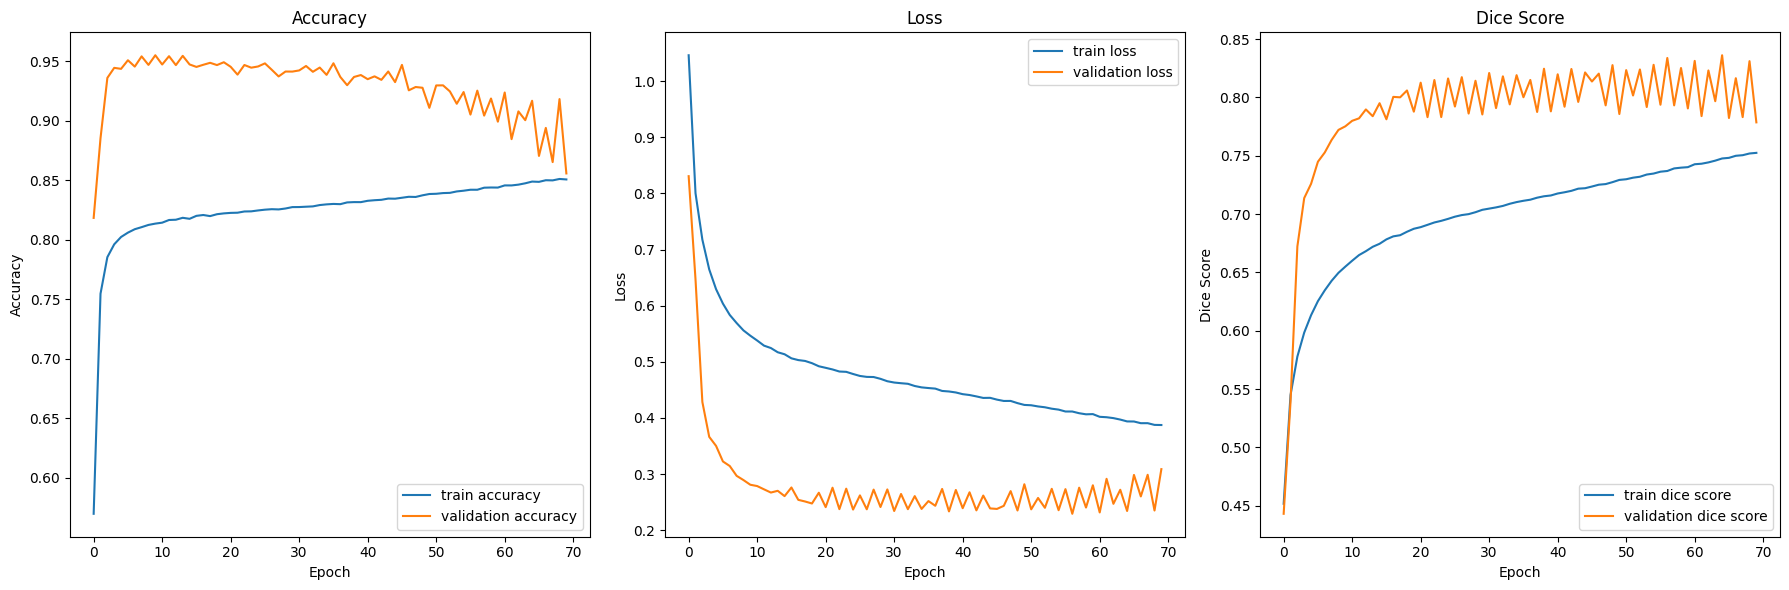

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    dice = history.history.get("dice_score")
    val_dice = history.history.get("val_dice_score")

    epochs_range = range(len(history.epoch))

    fig = plt.figure(figsize=(18,6))

    # Plot accuracy
    plt.subplot(1,3,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    # Plot loss
    plt.subplot(1,3,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # Plot Dice score
    if dice and val_dice:
        plt.subplot(1,3,3)
        plt.plot(epochs_range, dice, label="train dice score")
        plt.plot(epochs_range, val_dice, label="validation dice score")
        plt.title("Dice Score")
        plt.xlabel("Epoch")
        plt.ylabel("Dice Score")
        plt.legend(loc="lower right")

    fig.tight_layout()
    plt.show()

# Example usage
display_learning_curves(unet_model.history)


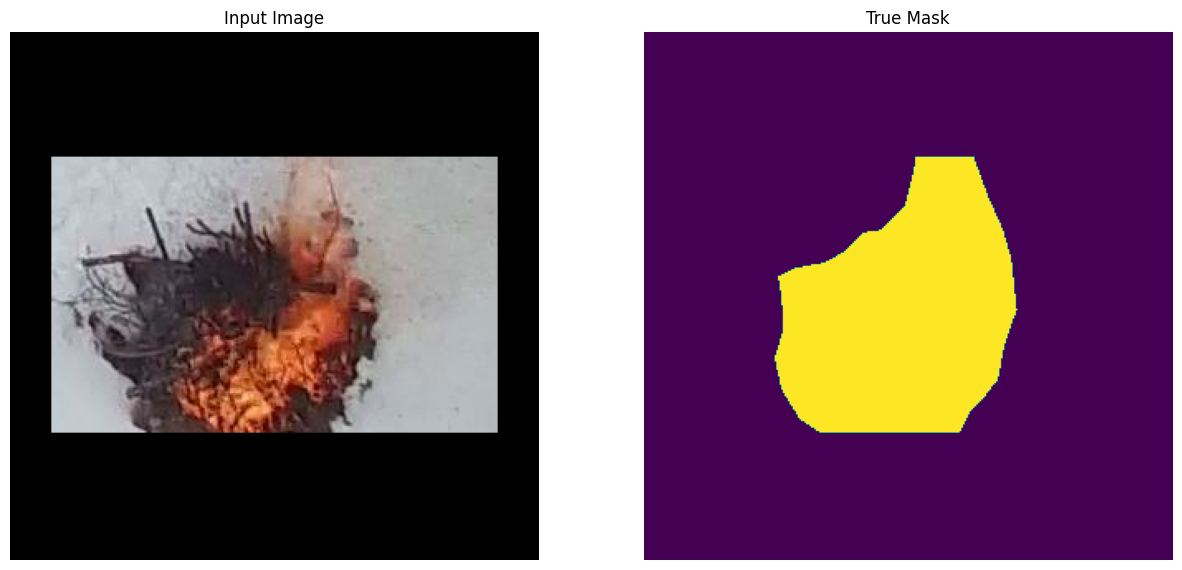

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()


sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


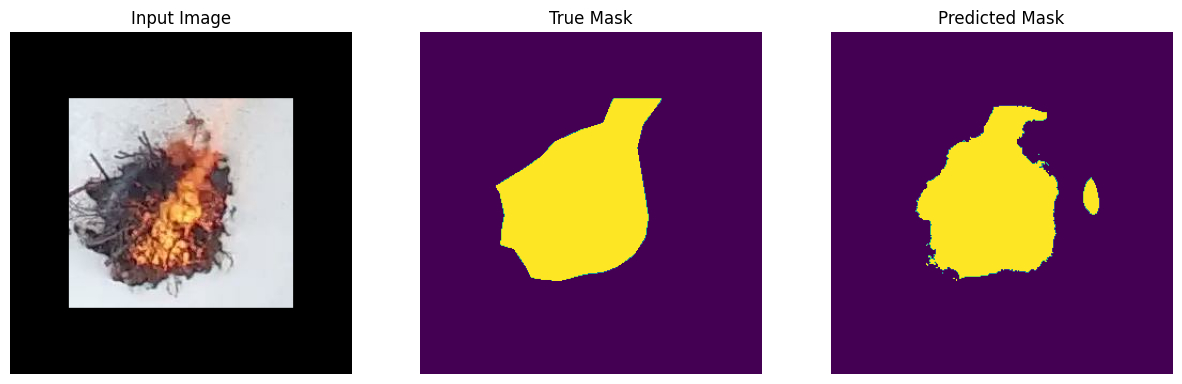

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


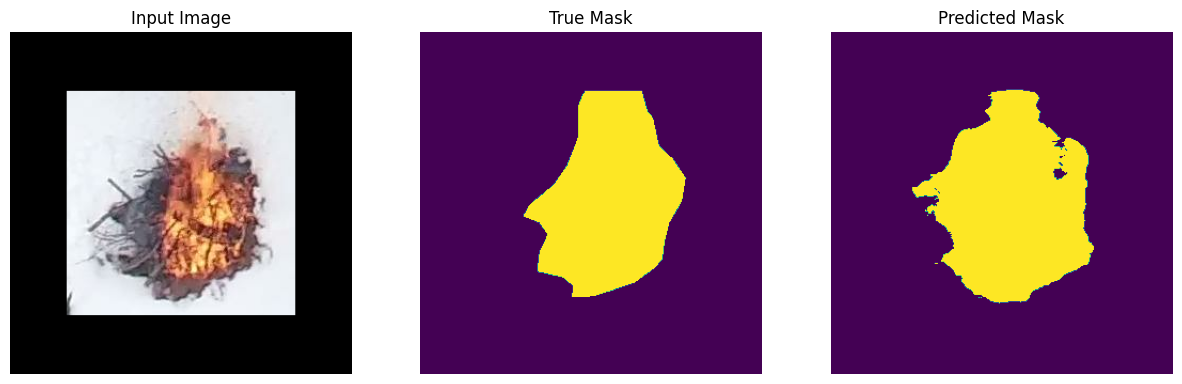

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


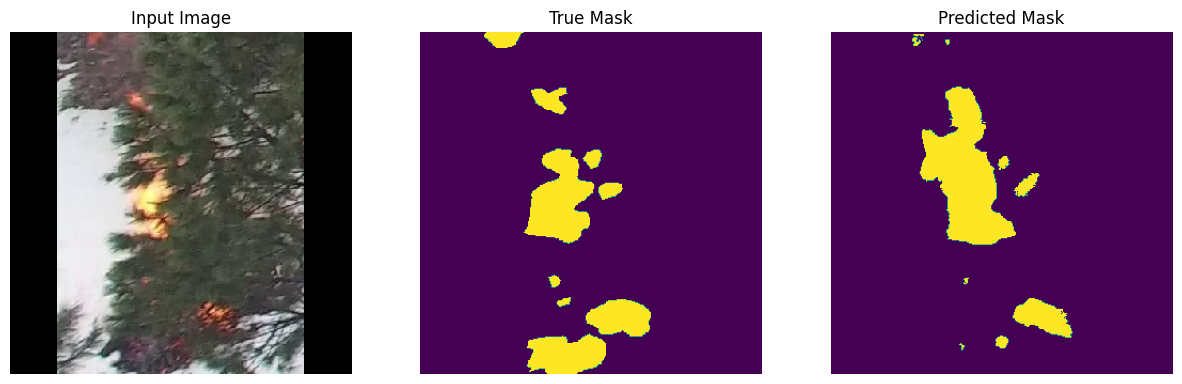

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
show_predictions(test_batches.skip(5), 3)